In [1]:
from google.colab import files

uploaded = files.upload()

Saving simpan_dataset_stok_alat_sewa.csv to simpan_dataset_stok_alat_sewa.csv


In [2]:
import pandas as pd

# Baca file CSV
df = pd.read_csv("simpan_dataset_stok_alat_sewa.csv")

# Tampilkan beberapa baris awal
df.head()

,Tanggal,Nama Barang,Jumlah
0,2024-01-01 0:00:00,"Tenda, Gas Rent",2.0
1,2024-01-03 0:00:00,"Tenda, Gas Tukar",2.0
2,2024-01-03 0:00:00,"Tenda, Matras, Kompor, Lampu, Kursi",9.0
3,2024-01-05 0:00:00,"Sarung Tangan, Headlamp, Cover Bag, Sepatu",4.0
4,2024-01-07 0:00:00,"Tenda, Gas Rent",2.0


In [3]:
# Filter hanya baris yang memiliki jumlah
df_filtered = df[df['Jumlah'].notnull()].copy()

# Bersihkan teks
df_filtered['Nama Barang'] = df_filtered['Nama Barang'].str.lower().str.strip()
# df_filtered['Toko/Pelanggan'] = df_filtered['Toko/Pelanggan'].str.title().str.strip() # This line caused the error

# Ubah tanggal jadi datetime
df_filtered['Tanggal'] = pd.to_datetime(df_filtered['Tanggal'], errors='coerce')

# Pecah nama barang menjadi beberapa baris
df_filtered['Nama Barang'] = df_filtered['Nama Barang'].str.split(', ')
df_exploded = df_filtered.explode('Nama Barang').reset_index(drop=True)

df_exploded.head()

,Tanggal,Nama Barang,Jumlah
0,2024-01-01,tenda,2.0
1,2024-01-01,gas rent,2.0
2,2024-01-03,tenda,2.0
3,2024-01-03,gas tukar,2.0
4,2024-01-03,tenda,9.0


In [4]:
from sklearn.preprocessing import LabelEncoder

# Fitur waktu (opsional)
df_exploded['Bulan'] = df_exploded['Tanggal'].dt.month

# Encoding nama barang and toko
le_barang = LabelEncoder()
# le_toko = LabelEncoder() # Removed as the column 'Toko/Pelanggan' does not exist

df_exploded['Barang_Encoded'] = le_barang.fit_transform(df_exploded['Nama Barang'])
# df_exploded['Toko_Encoded'] = le_toko.fit_transform(df_exploded['Toko/Pelanggan']) # Removed as the column 'Toko/Pelanggan' does not exist

# Fitur dan label
X = df_exploded[['Barang_Encoded', 'Bulan']] # Removed 'Toko_Encoded' from features
y = df_exploded['Jumlah']

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model prediksi
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Evaluasi
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 46.30030982858705


In [6]:
def kategorikan(jumlah):
    if jumlah <= 2:
        return 'Rendah'
    elif jumlah <= 6:
        return 'Sedang'
    else:
        return 'Tinggi'

df_exploded['Kategori_Jumlah'] = df_exploded['Jumlah'].apply(kategorikan)

In [7]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Fitur dan label
X_cls = df_exploded[['Barang_Encoded', 'Bulan']]
y_cls = df_exploded['Kategori_Jumlah']

# Encode label kategori
from sklearn.preprocessing import LabelEncoder
le_kat = LabelEncoder()
y_cls_encoded = le_kat.fit_transform(y_cls)

# Split data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls_encoded, test_size=0.2, random_state=42)

# Model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_cls, y_train_cls)

# Evaluasi
y_pred_cls = nb_model.predict(X_test_cls)
print(classification_report(y_test_cls, y_pred_cls, target_names=le_kat.classes_))

              precision    recall  f1-score   support

      Rendah       0.00      0.00      0.00        13
      Sedang       0.00      0.00      0.00        18
      Tinggi       0.58      1.00      0.73        42

    accuracy                           0.58        73
   macro avg       0.19      0.33      0.24        73
weighted avg       0.33      0.58      0.42        73



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


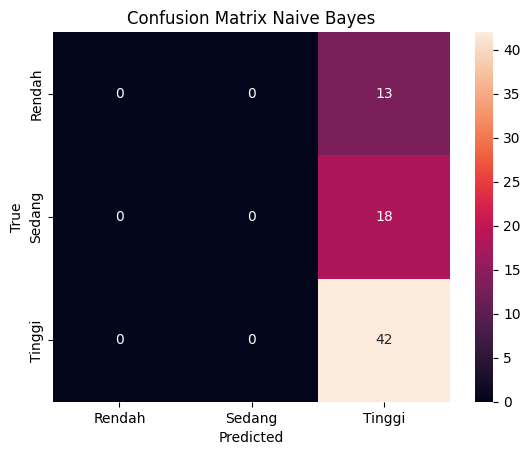

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, xticklabels=le_kat.classes_, yticklabels=le_kat.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Naive Bayes')
plt.show()

In [9]:
import joblib

# Simpan model regresi
joblib.dump(model, 'decision_tree_model.pkl')

# Simpan model klasifikasi
joblib.dump(nb_model, 'naive_bayes_model.pkl')

# Simpan encoders
joblib.dump(le_barang, 'le_barang.pkl')
# joblib.dump(le_toko, 'le_toko.pkl') # Removed as the variable is not defined
joblib.dump(le_kat, 'le_kat.pkl')  # untuk kategori jumlah (NB)

['le_kat.pkl']